# Mobile Price Range Prediction

## Objective
The goal of this project is to build a machine learning model that predicts the price range of mobile phones based on various specifications (battery power, RAM, camera quality, etc.). 

We will cover:
1. **Exploratory Data Analysis (EDA)**: Understanding the data.
2. **Data Preprocessing**: Preparing data for modeling.
3. **Model Selection & Tuning**: Using Ensemble learning and Grid Search.
4. **Evaluation**: Assessing model performance.
5. **Explainability**: Interpreting how the model makes decisions using SHAP.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Explainability
import shap

# Configuration for cleaner output
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

# Display settings for scrollable tables and better readability
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# CSS for scrollable notebook outputs
from IPython.display import HTML
HTML("""
<style>
.output {
    max-height: 400px;
    overflow-y: auto;
}
.dataframe {
    max-height: 400px;
    overflow-y: auto;
}
.jp-OutputArea-child {
    overflow-y: auto;
}
</style>
""")

# Configure matplotlib for better figure display
plt.rcParams['figure.max_open_warning'] = 50

c:\Users\nixon\jupyter_projects\mobile-price-prediction\.pixi\envs\default\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data Loading and Inspection

In [2]:
# Load the dataset
df_train = pd.read_csv('mobile_prices_data/train.csv')
df_test = pd.read_csv('mobile_prices_data/test.csv')

# Display first few rows
df_train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


In [3]:
# Check data types and missing values
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [4]:
# Statistical summary
df_train.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,9.916500,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,6.064315,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,0.000000,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,5.000000,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,10.000000,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,15.000000,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,20.000000,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


## 2. Exploratory Data Analysis (EDA)

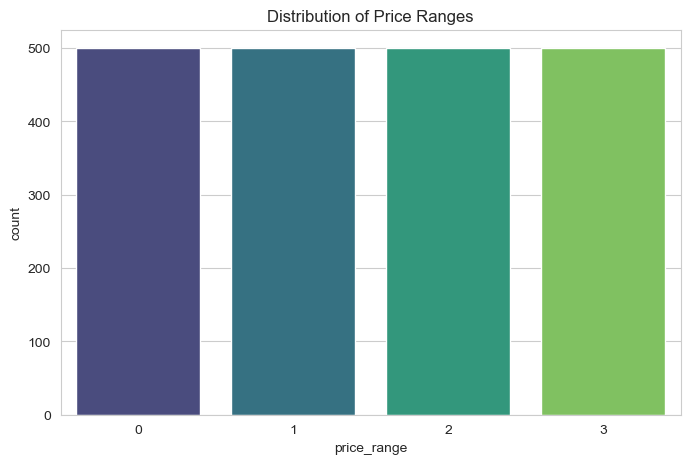

In [5]:
# Check for class balance
plt.figure(figsize=(8, 5))
sns.countplot(x='price_range', data=df_train, palette='viridis')
plt.title('Distribution of Price Ranges')
plt.show()

The target variable `price_range` seems well-balanced, which is great for training.

### Correlation Matrix
Let's see which features correlate most strongly with the price range.

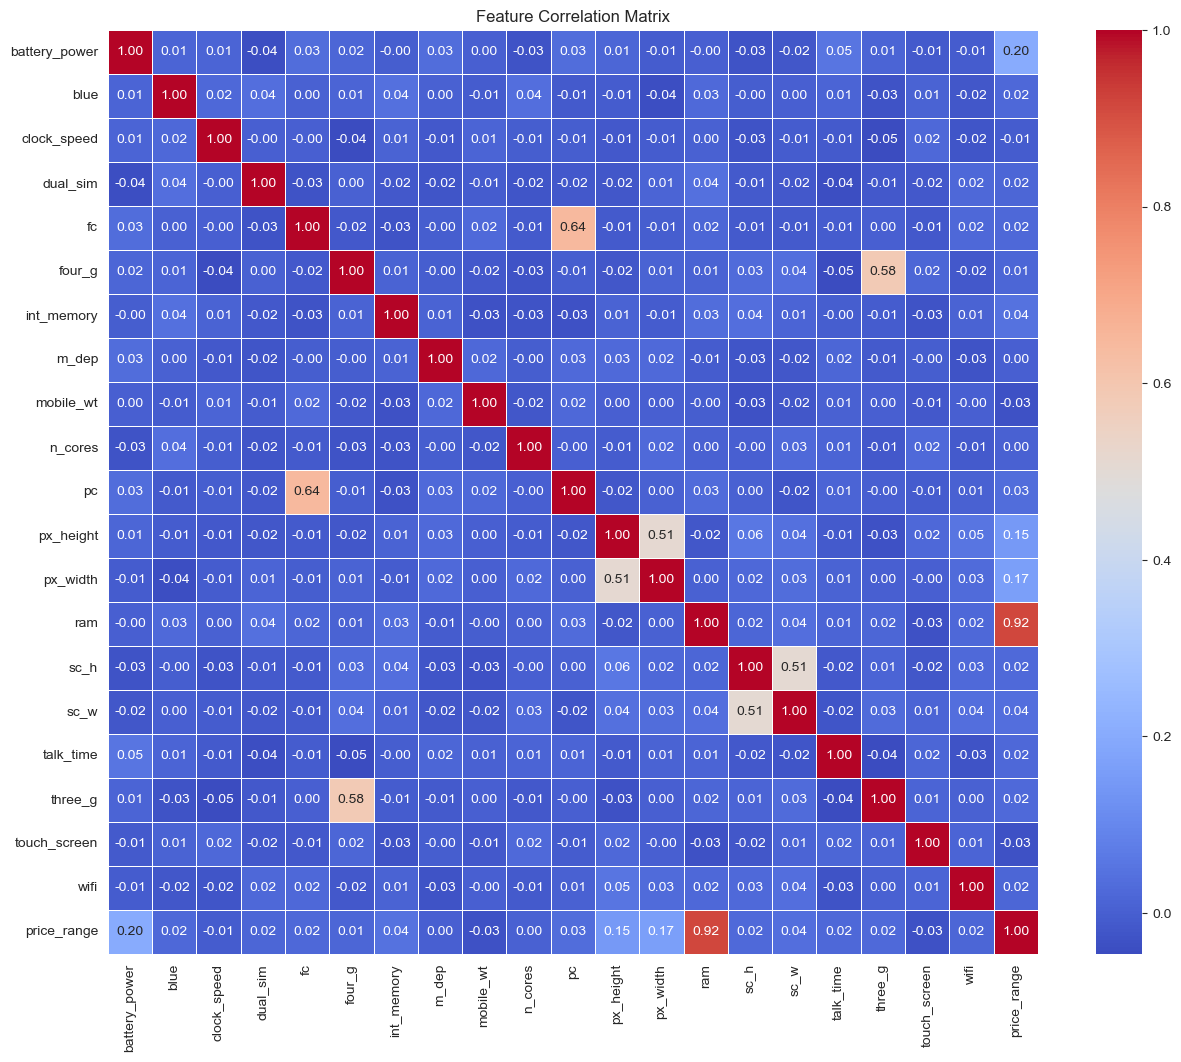

In [6]:
plt.figure(figsize=(15, 12))
correlation = df_train.corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

**Observation**: `ram` has a very high positive correlation with `price_range`. This suggests RAM is the most critical factor in pricing.

Let's visualize RAM vs Price Range.

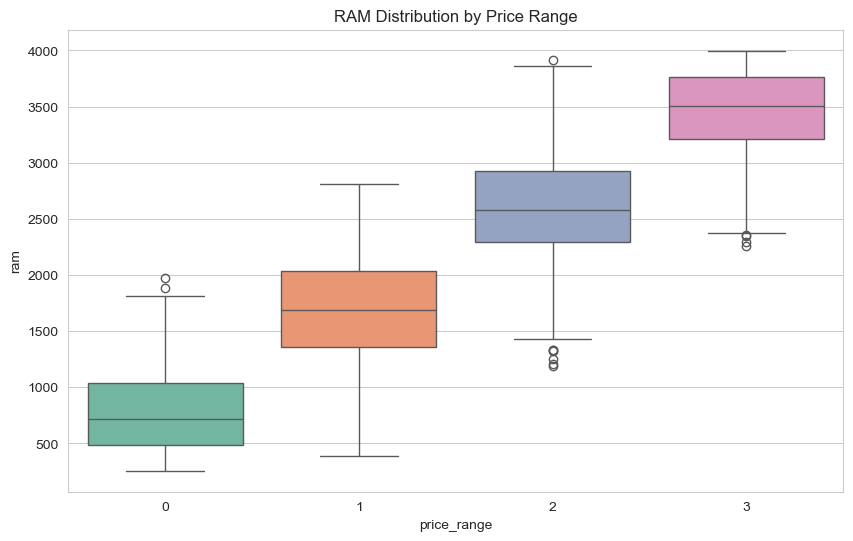

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='price_range', y='ram', data=df_train, palette='Set2')
plt.title('RAM Distribution by Price Range')
plt.show()

## 3. Data Preprocessing & Feature Engineering

In [8]:
# Feature Engineering: Calculate total screen area and pixel resolution
# This might help the model understand 'size' better than separate height/width
df_train['pixel_area'] = df_train['px_height'] * df_train['px_width']
df_train['screen_area'] = df_train['sc_h'] * df_train['sc_w']

# Separation of Features (X) and Target (y)
X = df_train.drop('price_range', axis=1)
y = df_train['price_range']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling is generally good practice, though Random Forests are robust to unscaled data.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

## 4. Model Selection & Hyperparameter Tuning

We will use a **Random Forest Classifier**. It is an ensemble learning method that operates by constructing a multitude of decision trees at training time. It is robust, handles non-linear relationships well, and offers good interpretability.

We will use `GridSearchCV` to automatically find the best hyperparameters.

In [9]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],      # Number of trees
    'max_depth': [None, 10, 20],     # Maximum depth of tree
    'min_samples_split': [2, 5],     # Minimum samples required to split a node
    'min_samples_leaf': [1, 2]       # Minimum samples required at each leaf node
}

# Initialize the classifier
rf = RandomForestClassifier(random_state=42)

# Initialize Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=1, scoring='accuracy')

# Fit the model
grid_search.fit(X_train_scaled, y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score: 0.8656


## 5. Model Evaluation

In [10]:
# Get the best model
best_model = grid_search.best_estimator_

# Predictions on validation set
y_pred = best_model.predict(X_val_scaled)

# Accuracy Score
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred))

Validation Accuracy: 0.8800

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       105
           1       0.85      0.86      0.85        91
           2       0.80      0.83      0.81        92
           3       0.92      0.89      0.90       112

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400



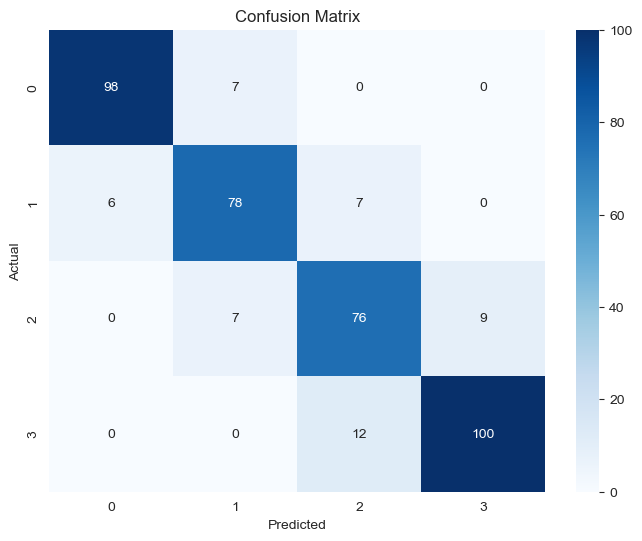

In [11]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 6. Explainability and Interpretability

To make the model interpretable, we will use two methods:
1. **Feature Importance Plot**: Built-in Random Forest importance.
2. **SHAP (SHapley Additive exPlanations)**: A game-theoretic approach to explain the output of any machine learning model.

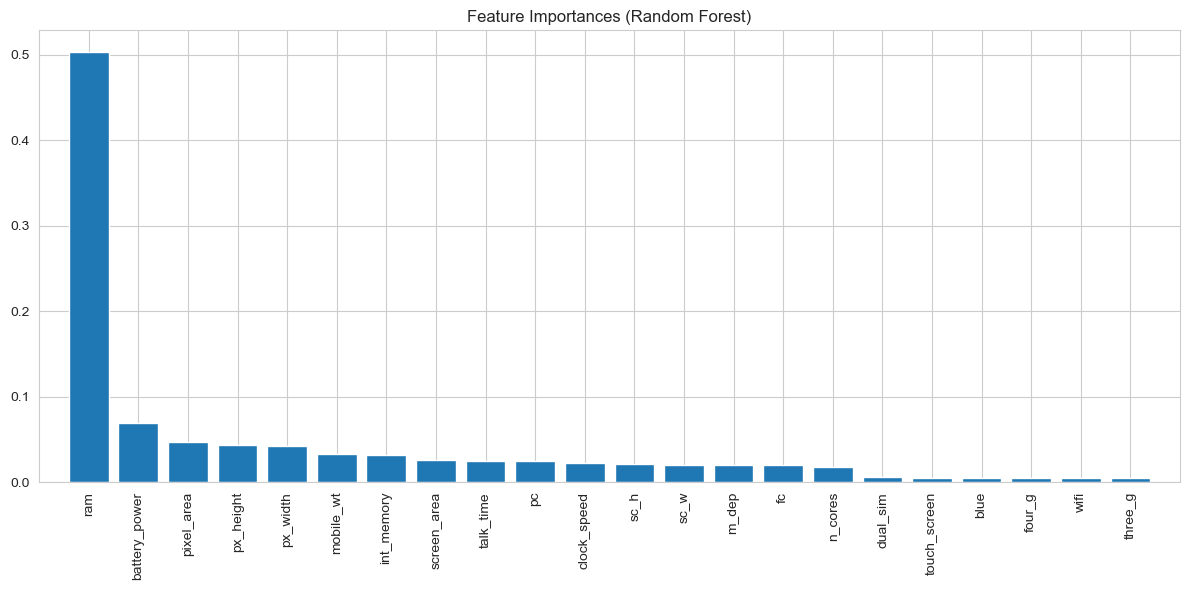

In [12]:
# Method 1: Feature Importance from Random Forest
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

SHAP Summary Plot (Feature Importance across all classes):


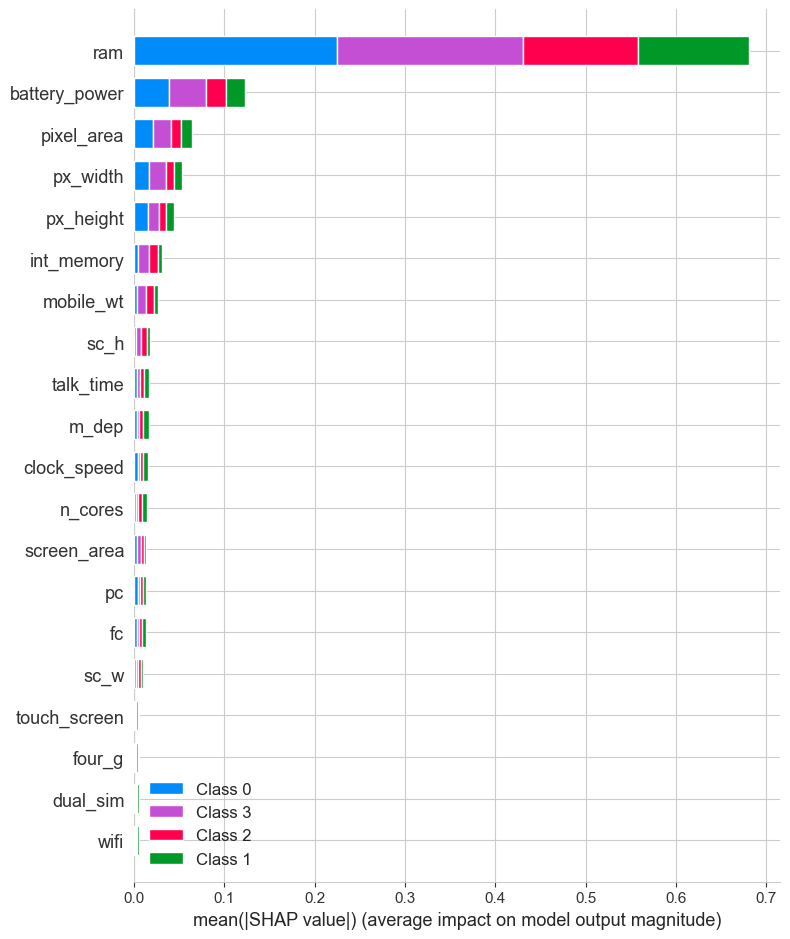

In [13]:
# Method 2: SHAP Values (Advanced Interpretability)
# SHAP explains the impact of each feature on the model's output for specific examples.

# Create a TreeExplainer
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values
# We disable additivity check as it sometimes fails with Random Forest due to precision issues
shap_values = explainer.shap_values(X_val_scaled, check_additivity=False)

# Summary Plot for multiclass classification
# Pass the entire shap_values array - SHAP will handle the multiclass visualization
print("SHAP Summary Plot (Feature Importance across all classes):")
shap.summary_plot(shap_values, X_val_scaled, plot_type="bar", feature_names=X.columns)

### Interpretation
The SHAP summary plot above shows the features sorted by importance.
- **RAM**: Is consistently the top driver. Low RAM pushes prediction towards lower price brackets (Class 0/1).
- **Battery Power**: High battery power contributes positively to maintaining higher price classes.
- **Pixel Area**: Screen resolution also plays a significant role.

## 7. Prediction on Test Data
Finally, we predict the price ranges for the unlabelled `test.csv` file.

In [ ]:
# Prepare test data
# Ensure we apply the same feature engineering
test_ids = df_test['id']
df_test_processed = df_test.drop('id', axis=1)
df_test_processed['pixel_area'] = df_test_processed['px_height'] * df_test_processed['px_width']
df_test_processed['screen_area'] = df_test_processed['sc_h'] * df_test_processed['sc_w']

# Scale using the same scaler fitted on training data
X_test_scaled = scaler.transform(df_test_processed)

# Predict
final_predictions = best_model.predict(X_test_scaled)

# Create results DataFrame
submission = pd.DataFrame({'id': test_ids, 'price_range': final_predictions})
submission.head(10)

,id,price_range
0,1,2
1,2,3
2,3,2
3,4,3
4,5,1
5,6,3
6,7,3
7,8,1
8,9,3
9,10,0
